数据来源：
本次实验选取的数据来自B站播放量靠前的关于对“封校”、“大学生封校日常”、“大学生封校精神状态”视频下的评论。
https://www.bilibili.com/video/BV13S4y127YT/?spm_id_from=333.337.search-card.all.click&vd_source=dd5cc72c304ae32d0dc30e29b2abbac7
https://www.bilibili.com/video/BV1RA4y197hF/?spm_id_from=333.337.search-card.all.click
https://www.bilibili.com/video/BV1g34y1Z7nP/?spm_id_from=333.337.search-card.all.click
https://www.bilibili.com/video/BV1jL411A7Yu/?spm_id_from=333.337.search-card.all.click&vd_source=dd5cc72c304ae32d0dc30e29b2abbac7

关于数据清洗：
关于停用词本次实验使用了gtihub上常用的中文停用词表，并在多次实验过程中往表中新增了一些无意义、干扰实验结果的词汇。
去除了评论中的表情及b站常见的表情转文字后的描述

关于实验存在的问题：
数据集不够大
数据的清洗不够完善，还存在一些干扰。
情感倾向分析是借用的百度开源api来实现，没有自己训练模型

爬取数据：

In [ ]:
import requests
import re
import time
import csv

#消息头信息
header = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36 SLBrowser/8.0.0.6271 SLBChan/25',
}
#获取评论API
original_url = 'https://api.bilibili.com/x/v2/reply/main?jsonp=jsonp&next={}&type=1&oid={}&mode=3'

#时间戳转换成日期
def get_time(ctime):
    timeArray = time.localtime(ctime)
    otherStyleTime = time.strftime("%Y.%m.%d", timeArray)
    return str(otherStyleTime)

#获取aid
def get_oid(bvid):
    video_url = 'https://www.bilibili.com/video/' + bvid
    page = requests.get(video_url, headers=header).text
    aid = re.search(r'"aid":[0-9]+', page).group()[6:]
    return aid

#边爬取评论边保存文件
def online_save(Bvid):
    all_count = 0
    oid = get_oid(Bvid)
    page = 1
    url = original_url.format(page, oid)
    html = requests.get(url, headers=header)
    data = html.json()
    count = int(data['data']['cursor']['all_count'])
    fname = Bvid + '_评论.csv'
    with open(fname, 'w+', newline='', encoding='utf_8_sig') as f:
        csv_writer=csv.writer(f)
        csv_writer.writerow(["时间", "点赞", "评论"])
        for i in data['data']['replies']:
            message=i['content']['message']
            message = re.sub('\s+', '', message)
            ctime=get_time(i['ctime'])
            like=i['like']
            csv_writer.writerow([ctime,str(like),message])
            all_count = all_count + 1
        print('总评论数：{}，当前评论数:{},爬取Page{}完毕。'.format(count, all_count, page))
        time.sleep(1)
        while all_count < count:
            page += 1
            url = original_url.format(page, oid)
            try:
                html = requests.get(url, headers=header,timeout=20)
                data = html.json()
                for i in data['data']['replies']:
                    message = i['content']['message']
                    ctime = get_time(i['ctime'])
                    like = i['like']
                    csv_writer.writerow([ctime, str(like), message])
                    # f.write(ctime+'\t' + str(like) + '\n')
                    # f.write(message)
                    # f.write('\n------------------------\n')
                    all_count = all_count + 1
                print('总评论数：{}，当前评论数:{},爬取Page{}完毕。'.format(count, all_count, page))
                time.sleep(1)
            except:
                break
        f.close()

if __name__=='__main__':
    Bvid=input('输入视频Bvid:')
    online_save(Bvid)
    print('完成！')

一、导入项目所需的依赖

In [353]:
import pandas as pd
import csv
import jieba
import numpy as np
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import os
import math
import operator
import codecs
from collections import defaultdict
import jieba.posseg as jp
from gensim import corpora, models

In [377]:
#停用词
stop_words = readStopWords()
#关键词列表
keywordsstr = ''

二、定义所需函数

In [355]:
# 读取评论数据
def readData(path):
    return pd.read_csv(path)

In [356]:
 # 过滤表情
def filter_emoji(desstr, restr=''):
    try:
        co = re.compile(u'[\U00010000-\U0010ffff]')
    except re.error:
        co = re.compile(u'[\uD800-\uDBFF][\uDC00-\uDFFF]')
    return co.sub(restr, desstr)

In [357]:
# 评论写进评论汇总字典
def writeToDic(dicPath,commentsPath):
    data = readData(commentsPath)
    dic = open(dicPath,mode='w',encoding='utf-8')
    for index in data.index:
        data.loc[index,'评论'] = filter_emoji(data.loc[index,'评论'])
        data.loc[index,'评论'] = re.sub(r'[\[](.*?)[\]]',"",data.loc[index,'评论'])
        dic.write(data.loc[index,'评论']+'\n')
    dic.close()

In [37]:
#读取停用词表
def readStopWords():
    # 停用词
    stopwords = []
    f = open("./stopwords-master/cn_stopwords.txt","r",encoding="utf-8")
    lines = f.readlines()
    for line in lines:
        words = line.split("\n")
        stopwords.append(words[0])
    f.close()
    return stopwords

In [359]:
# 读取文件
def readfile(path):
    fp = open(path, "rb")
    content = fp.read()
    fp.close()
    return content

In [360]:
# 分词
def segment(path):
    text = readfile(path).strip()
    text = text.decode('utf-8')
    text = text.replace("\r\n", "")
    cut_text = " ".join(jieba.cut(text,cut_all=False))
    return cut_text

In [361]:
# 生成词云图
def showWordCloud(cut_text):
    wordcloud = WordCloud(
        font_path="./font/msyh.ttc",
        stopwords = stop_words,
        width=1000,
        height=800
    ).generate(cut_text)
    # plt.imshow(wordcloud,interpolation="biliner")
    # plt.axis("off")
    # plt.show()
    # 保存词云图
    wordcloud.to_file(cut_text + '.png')

In [362]:
#去除停用词
def clear(wordlist,stw):
    newlist = []
    for i in wordlist:
        if(i in stw):
            continue
        else:
            newlist.append(i)
    return newlist

#去除停用词
def clear2(s,stw):
    newStr = ''
    for i in s:
        if(i in stw):
            continue
        else:
            newStr = newStr + i
    return newStr


In [363]:
# 高频词写进词典
def writeWord(dicPath,d):
    data = d
    dic = open(dicPath,mode='wb')
    for index in data.index:        
        print(data.loc[index,'word'])
        dic.write(data.loc[index,'word']+'\n')
    dic.close()

三、将清洗过的数据写入txt文档

In [364]:
writeToDic('./data/评论1.txt','BV1g34y1Z7nP_评论.csv')
writeToDic('./data/评论2.txt','BV1jL411A7Yu_评论.csv')
writeToDic('./data/评论3.txt','BV1RA4y197hF_评论.csv')
writeToDic('./data/评论4.txt','BV13S4y127YT_评论.csv')

四、用词云渲染出4个文档的词云
（生成时去掉了一些停用词，字体越大代表词频越高）

In [365]:
def showWordsCloud(path):
    wordcloud = WordCloud(
        font_path="./font/msyh.ttc",
        stopwords = stop_words,
        width=1000,
        height=800
    ).generate(segment('./data/'+path+'.txt'))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    wordcloud.to_file(path+'.png')

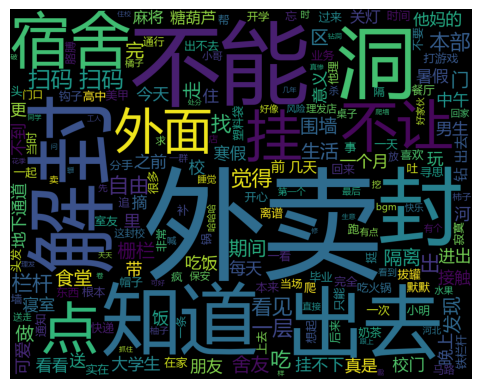

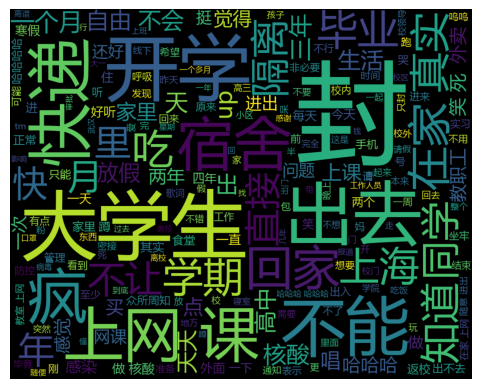

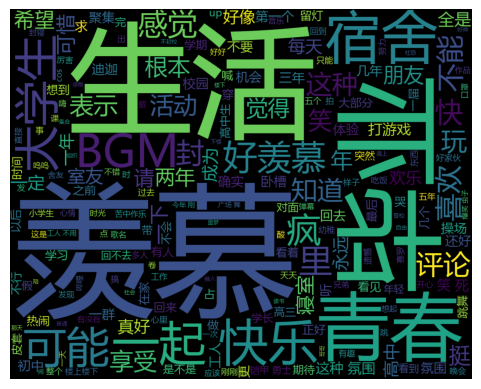

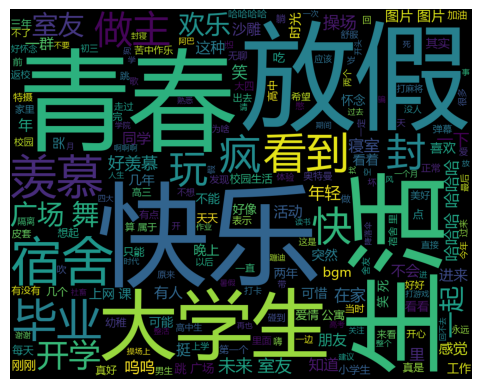

In [368]:
#分别生成四个文档的词云图片
showWordsCloud('评论1')
showWordsCloud('评论2')
showWordsCloud('评论3')
showWordsCloud('评论4')

In [ ]:
通过词云的展现，发现几个视频下的评论出现的高频词汇大同小异。

五、通过tf-idf分析数据的主题词

上述说到通过词云我们可以知道每个视频下对于封校和封校日常等的高频出现词汇，但为了更进一步发掘各视频下评论的其他特征，
于是通过计算各个数据集词汇的tfidf值来区分每个视频对于封校讨论的主题词。

In [389]:
from collections import Counter
corpus = handleAllContent()
#对语料进行分词
word_list = []
for i in range(len(corpus)):
    word_list.append(corpus[i].split(' '))
#统计词频
countlist = []
for i in range(len(word_list)):
    count = Counter(word_list[i])
    countlist.append(count)
countlist
#定义计算tfidf公式的函数
# word可以通过count得到，count可以通过countlist得到

# count[word]可以得到每个单词的词频， sum(count.values())得到整个句子的单词总数
def tf(word, count):
    return count[word] / sum(count.values())

# 统计的是含有该单词的句子数
def n_containing(word, count_list):
    return sum(1 for count in count_list if word in count)
 
# len(count_list)是指句子的总数，n_containing(word, count_list)是指含有该单词的句子的总数，加1是为了防止分母为0
def idf(word, count_list):
    return math.log(len(count_list) / (1 + n_containing(word, count_list)))

# 将tf和idf相乘
def tfidf(word, count, count_list):
    return tf(word, count) * idf(word, count_list)
#计算每个单词的tfidf值
for i, count in enumerate(countlist):
    print("视频 {}".format(i + 1))
    scores = {word: tfidf(word, count, countlist) for word in count}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:5]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

视频 1
	Word: 解封, TF-IDF: 0.00477
	Word: 扫码, TF-IDF: 0.00477
	Word: 一层, TF-IDF: 0.00298
	Word: 本部, TF-IDF: 0.00298
	Word: 接触, TF-IDF: 0.00179
视频 2
	Word: 上网, TF-IDF: 0.00162
	Word: 教职工, TF-IDF: 0.00161
	Word: 核酸, TF-IDF: 0.00117
	Word: 家里, TF-IDF: 0.00106
	Word: 非必要, TF-IDF: 0.00081
视频 3
	Word: 好羡慕, TF-IDF: 0.00151
	Word: 氛围, TF-IDF: 0.00128
	Word: 留灯, TF-IDF: 0.00112
	Word: 享受, TF-IDF: 0.00093
	Word: 五年, TF-IDF: 0.00084
视频 4
	Word: 做主, TF-IDF: 0.00296
	Word: 年轻, TF-IDF: 0.00111
	Word: 好羡慕, TF-IDF: 0.00092
	Word: 走过, TF-IDF: 0.00089
	Word: 乐队, TF-IDF: 0.00089


以上是各个视频前5的tfidf特征，由此我们得到了每个视频的评论区别于其他视频的特征。

六、情感倾向分析

这里借用百度开源的api对评论进行情感倾向分析

In [163]:
# 使用百度api必要的一些准备
import aip
APP_ID = '28539594'
API_KEY = 'WppbomeIAhGXB67PBZpyPqWR'
SECRET_KEY = 'q0mXTF3qGVv2ndLo44LmY8kPTwvczOmH'
nlp = aip.nlp.AipNlp(APP_ID, API_KEY, SECRET_KEY)

In [204]:
# 将所有评论读到列表中
def readDict():
    wordList = []
    for i in range(4):        
        f=open("./data/评论"+str(i+1)+".txt","r",encoding='utf-8')
        lines=f.readlines()
        for line in lines:
            words = line.split("\n")
            wordList.append(words[0])
        f.close()
    return wordList
wordList = readDict()

In [261]:
comments_list = []
for i in wordList:
    comments_list.append({'comments':i})

In [199]:
import time
'''
获取所有的评论信息及评论情感预测信息
'''
def getAllSentiments(comments_list):

    #存放所有评论及情感预测信息的列表
    comment_sentiments = []

    #循环遍历所有评论，并预测评论的情感
    for comment in comments_list:

        #异常处理，防止评论出现特殊字符导致程序异常终止
        try:

            #使用 Baidu AI的NLP自然语言处理接口.进行评论情感分析，并返回分析结果
            sentiment_result = nlp.sentimentClassify(comment['comments'])['items'][0]

            #以下为 sentiment_result 内的参数属性
            # confidence----代表可信度
            # negative_prob----代表消极情绪概率
            # positive_prob----代表积极情绪概率
            # sentiment----代表情绪识别结果，0为消极，1为中性，2为积极

            #封装评论及预测，并添加到预测列表中
            comment_sentiment = {
                'comment': comment['comments'],          #评论内容
                #format()函数统一将 小数数据 转化为 百分比数据
                'positive_prob': format(sentiment_result['positive_prob'], '.2%'),      #情绪积极概率
                'negative_prob': format(sentiment_result['negative_prob'], '.2%'),      #情绪消极概率
                'sentiment': sentiment_result['sentiment'],         #情绪结果
                'confidence': format(sentiment_result['confidence'], '.2%'),        #可信度概率
            }

            print(comment_sentiment)                #输出封装好的数据

            comment_sentiments.append(comment_sentiment)        #添加到情绪列表之中

        except Exception:
            pass

        time.sleep(1)                 #由于百度情绪识别的请求接口存在并发限制，故每1s请求一次

    return comment_sentiments           #返回所有情绪结果


In [207]:
import xlwt
'''
信息保存至Excel表格
'''
def saveExcel(comment_sentiments):

    #Step1: 创建excel表格类型文件，即工作薄对象，编码格式为 utf-8
    workbook = xlwt.Workbook(encoding='utf-8')

    #Step2: 创建工作表对象
    worksheet = workbook.add_sheet('sentiment analysis')

    #Step3: 设置表头信息
    worksheet.write(0, 0, '评论内容')
    worksheet.write(0, 1, '积极概率')
    worksheet.write(0, 2, '消极概率')
    worksheet.write(0, 3, '情绪结果(0消极、1中性、2积极)')
    worksheet.write(0, 4, '可信度')

    #Step4: 将所有的评论情绪信息写入Excel表格之中
    for i in range(len(comment_sentiments)):
        worksheet.write(i+1, 0, comment_sentiments[i]['comment'])
        worksheet.write(i+1, 1, comment_sentiments[i]['positive_prob'])
        worksheet.write(i+1, 2, comment_sentiments[i]['negative_prob'])
        worksheet.write(i+1, 3, comment_sentiments[i]['sentiment'])
        worksheet.write(i+1, 4, comment_sentiments[i]['confidence'])

    #Step5: 保存Excel文件至本地
    workbook.save('./sentiment.xls')

    #打印保存信息
    print('Save Successfully!')



In [208]:
# 这个单元格不要轻易动，不然会跑很久
if __name__ == '__main__':
    comment_sentiments = getAllSentiments(comments_list)
    saveExcel(comment_sentiments)

{'comment': '这几年大学生生活是真惨。。本来处在花季。就该走出去多看看。。完全卷学校里跟上高中也没2样', 'positive_prob': '3.41%', 'negative_prob': '96.59%', 'sentiment': 0, 'confidence': '92.43%'}
{'comment': '我们学校也有一个会理发的同学，生意可好了', 'positive_prob': '93.11%', 'negative_prob': '6.89%', 'sentiment': 2, 'confidence': '84.69%'}
{'comment': '我们学校要不是说抓住爬墙钻洞的就处分，那个修栏杆的工人得天天往我们学校跑。一天破一个洞，补都补不过来', 'positive_prob': '0.27%', 'negative_prob': '99.73%', 'sentiment': 0, 'confidence': '99.41%'}
{'comment': '不懂就问为什么老师不一起住校他们用腮呼吸吗？', 'positive_prob': '0.55%', 'negative_prob': '99.45%', 'sentiment': 0, 'confidence': '98.78%'}
{'comment': '同班男生已经在男生宿舍搞起了拔罐业务，人微信昵称“拔罐师傅代号小明”，一提他真名没人认识，一说小明，大家都知道是谁', 'positive_prob': '4.56%', 'negative_prob': '95.44%', 'sentiment': 0, 'confidence': '89.87%'}
{'comment': '你们只是封校，而我们是封寝，一日三餐由志愿者配送，连寝室门你都出不去！', 'positive_prob': '0.35%', 'negative_prob': '99.65%', 'sentiment': 0, 'confidence': '99.22%'}
{'comment': '啊这，我们学校有一小片的栅栏被干倒了建筑大学具体哪不能说要命这就叫学以致用，感谢牛顿爵爷', 'positive_prob': '15.02%', 'negative_prob': '84.98%', 'sen

{'comment': '求bgm?', 'positive_prob': '1.83%', 'negative_prob': '98.17%', 'sentiment': 0, 'confidence': '95.93%'}
{'comment': '呵，我们每天早上要做早操，就离谱', 'positive_prob': '0.66%', 'negative_prob': '99.34%', 'sentiment': 0, 'confidence': '98.53%'}
{'comment': '道高一尺，魔高一丈，只要想要自由，处处都是一方通行', 'positive_prob': '99.44%', 'negative_prob': '0.56%', 'sentiment': 2, 'confidence': '98.76%'}
{'comment': '好可爱的一群人', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.97%'}
{'comment': '铁窗泪', 'positive_prob': '100.00%', 'negative_prob': '0.00%', 'sentiment': 1, 'confidence': '100.00%'}
{'comment': '真好，我们大学没有门，没你们那么欢乐', 'positive_prob': '99.82%', 'negative_prob': '0.18%', 'sentiment': 2, 'confidence': '99.59%'}
{'comment': '想起高中时在四楼，楼下有个卖糖葫芦的，然后我们把钱丢下去，卖糖葫芦的把糖葫芦扔上来，虽然摔碎了很多颗，但就是很快乐', 'positive_prob': '77.24%', 'negative_prob': '22.76%', 'sentiment': 2, 'confidence': '49.43%'}
{'comment': '对不起，封校不停课', 'positive_prob': '0.09%', 'negative_prob': '99.91%', 'sentiment': 0, 'confiden

{'comment': '我们开学即封校', 'positive_prob': '98.98%', 'negative_prob': '1.02%', 'sentiment': 2, 'confidence': '97.73%'}
{'comment': '看到我们学校了哈哈哈哈，蚌埠住了，现在还在封校', 'positive_prob': '99.74%', 'negative_prob': '0.26%', 'sentiment': 2, 'confidence': '99.41%'}
{'comment': '唉，疫情还我大学生活', 'positive_prob': '2.14%', 'negative_prob': '97.86%', 'sentiment': 0, 'confidence': '95.24%'}
{'comment': '我想出校吃火锅', 'positive_prob': '96.33%', 'negative_prob': '3.67%', 'sentiment': 2, 'confidence': '91.84%'}
{'comment': '求BGM', 'positive_prob': '96.10%', 'negative_prob': '3.90%', 'sentiment': 2, 'confidence': '91.33%'}
{'comment': '就没解封过', 'positive_prob': '2.15%', 'negative_prob': '97.85%', 'sentiment': 0, 'confidence': '95.21%'}
{'comment': '@Anhedonia乔 看看这个视频开心点', 'positive_prob': '87.43%', 'negative_prob': '12.57%', 'sentiment': 2, 'confidence': '72.07%'}
{'comment': '无所不能？不能外出！', 'positive_prob': '0.61%', 'negative_prob': '99.39%', 'sentiment': 0, 'confidence': '98.64%'}
{'comment': '第一个好像是我们学校。。', 'positive_pr

{'comment': '7+7+7+7+7+7+… 太伤了', 'positive_prob': '0.22%', 'negative_prob': '99.78%', 'sentiment': 0, 'confidence': '99.50%'}
{'comment': '安医大送来贺电', 'positive_prob': '98.13%', 'negative_prob': '1.87%', 'sentiment': 2, 'confidence': '95.84%'}
{'comment': '我已经不在乎能不能出学校取外卖了，就让我们出个寝室门行不行，求求了，我已经将近一个月没洗澡了，受不了的时候只能和舍友轮流在阳台拿盆随便洗洗，吃饭也吃不饱，用塑料袋装着送的米饭套餐能油死，都快吃吐了，我同学好多闹肚子的，再不出去透透气我们没得新冠也先饿死臭死在宿舍了', 'positive_prob': '0.00%', 'negative_prob': '100.00%', 'sentiment': 0, 'confidence': '100.00%'}
{'comment': '疯了两学期的江师大送来贺电', 'positive_prob': '74.76%', 'negative_prob': '25.24%', 'sentiment': 2, 'confidence': '43.92%'}
{'comment': '直接半封闭，一半封闭的是学生，不封闭的是老师', 'positive_prob': '1.15%', 'negative_prob': '98.85%', 'sentiment': 0, 'confidence': '97.44%'}
{'comment': '如果可能 我希望用感染新冠换回我的人醛 和正常的生活', 'positive_prob': '30.05%', 'negative_prob': '69.95%', 'sentiment': 0, 'confidence': '33.23%'}
{'comment': '同学你好，我是学校领导，你写的小作文针砭时弊，振聋发聩，我们深感惭愧，为了奖励你，请把你的学号和姓名告诉我，给你加创新学分', 'positive_prob': '84.14%', 'negative_prob': '15.

{'comment': '四川大学生表示感谢川大', 'positive_prob': '98.34%', 'negative_prob': '1.66%', 'sentiment': 2, 'confidence': '96.32%'}
{'comment': '疫情前是怎么样的来着', 'positive_prob': '42.99%', 'negative_prob': '57.01%', 'sentiment': 0, 'confidence': '4.47%'}
{'comment': '看到闵行为之一惊，以为是自己学校，原来是隔壁啊，打扰了', 'positive_prob': '1.02%', 'negative_prob': '98.98%', 'sentiment': 0, 'confidence': '97.73%'}
{'comment': '行吧，就这样吧。', 'positive_prob': '0.05%', 'negative_prob': '99.95%', 'sentiment': 0, 'confidence': '99.89%'}
{'comment': '本地大学牲国庆想回家啊', 'positive_prob': '98.18%', 'negative_prob': '1.82%', 'sentiment': 2, 'confidence': '95.96%'}
{'comment': '看着看着就哭了。', 'positive_prob': '44.24%', 'negative_prob': '55.76%', 'sentiment': 0, 'confidence': '1.69%'}
{'comment': '告诉你们一个秘密：以前的大学是可以随意进出的。', 'positive_prob': '59.61%', 'negative_prob': '40.39%', 'sentiment': 2, 'confidence': '10.24%'}
{'comment': '上海南京要恢复高铁', 'positive_prob': '71.07%', 'negative_prob': '28.93%', 'sentiment': 2, 'confidence': '35.71%'}
{'comment': '不是，上海不

{'comment': '众所周知，只有大学生会感染病毒', 'positive_prob': '2.81%', 'negative_prob': '97.19%', 'sentiment': 0, 'confidence': '93.76%'}
{'comment': '韵脚i', 'positive_prob': '99.87%', 'negative_prob': '0.13%', 'sentiment': 2, 'confidence': '99.71%'}
{'comment': '每天早点五点做核酸属实把我整笑了，做了一周多了', 'positive_prob': '88.65%', 'negative_prob': '11.35%', 'sentiment': 2, 'confidence': '74.78%'}
{'comment': '我怎么感觉说的是某政法大学', 'positive_prob': '3.21%', 'negative_prob': '96.79%', 'sentiment': 0, 'confidence': '92.87%'}
{'comment': '4.16抗疫日记', 'positive_prob': '99.48%', 'negative_prob': '0.52%', 'sentiment': 2, 'confidence': '98.84%'}
{'comment': '又是为抗疫献绵薄之力的一天，口罩库存已经见底了，暂不晓得哪里可以取得口罩?', 'positive_prob': '0.16%', 'negative_prob': '99.84%', 'sentiment': 0, 'confidence': '99.64%'}
{'comment': '今天听闻沈阳部分重点高校率先恢复快递的消息，想起了在那里念书的同学，不由得为他们感到高兴，如果有机会重来，我也一定会努力考取一所这样的学校吧，也以此坚定了考研的决心？', 'positive_prob': '98.54%', 'negative_prob': '1.46%', 'sentiment': 2, 'confidence': '96.75%'}
{'comment': '算起来，大学生活四年，三年半都被疫情夺去了，仍不知道疫情会持续多久，也许有一天疫情

{'comment': '高中还周末回家，大学一个学期怪怪待在校区', 'positive_prob': '98.06%', 'negative_prob': '1.94%', 'sentiment': 2, 'confidence': '95.69%'}
{'comment': '我们倒是没封，可我在家上网课上到现在', 'positive_prob': '28.49%', 'negative_prob': '71.51%', 'sentiment': 0, 'confidence': '36.68%'}
{'comment': '这是什么，这就是我真实的大学生活', 'positive_prob': '98.68%', 'negative_prob': '1.32%', 'sentiment': 2, 'confidence': '97.06%'}
{'comment': '你怎么知道我从开学就没回家', 'positive_prob': '2.53%', 'negative_prob': '97.47%', 'sentiment': 0, 'confidence': '94.38%'}
{'comment': '我说个笑话，27个月，我隔离了13个月', 'positive_prob': '0.83%', 'negative_prob': '99.17%', 'sentiment': 0, 'confidence': '98.16%'}
{'comment': '有的吃不错了，坐标上海浦东，封了3周，每天都是忙着抢吃的，超市全关门啥都没了', 'positive_prob': '81.53%', 'negative_prob': '18.47%', 'sentiment': 2, 'confidence': '58.95%'}
{'comment': '复旦也封了姐妹你们7+7指的是啥哇', 'positive_prob': '11.58%', 'negative_prob': '88.42%', 'sentiment': 0, 'confidence': '74.26%'}
{'comment': '七天洗了一次', 'positive_prob': '52.36%', 'negative_prob': '47.64%', 'sentiment': 1, '

{'comment': '有才', 'positive_prob': '96.24%', 'negative_prob': '3.76%', 'sentiment': 2, 'confidence': '91.64%'}
{'comment': '我们大学里头甚至有居民区（就天天去校门口拿快递都能看见大人带小孩随便骑电瓶车进校园）然后我们连外卖都不给点，学校食堂又小还贵死', 'positive_prob': '0.07%', 'negative_prob': '99.93%', 'sentiment': 0, 'confidence': '99.84%'}
{'comment': '你封任你封，大哥背行囊', 'positive_prob': '45.40%', 'negative_prob': '54.60%', 'sentiment': 1, 'confidence': '7.91%'}
{'comment': '唱的真好', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.99%'}
{'comment': '我们学校是教职工可以自由进出，大三的因为实习也可以。就大一大二不行，我们学校是两个校区隔了马路，对面校区过来需要老师带着还点人数。出去可以但是三级审批有点麻烦 我们宿舍就出过去 ，她们是一个平板充不了电，一个手机开不了机审批完后就放了', 'positive_prob': '8.11%', 'negative_prob': '91.89%', 'sentiment': 0, 'confidence': '81.97%'}
{'comment': '徐汇校区贺电', 'positive_prob': '98.31%', 'negative_prob': '1.69%', 'sentiment': 2, 'confidence': '96.24%'}
{'comment': '火钳刘明', 'positive_prob': '98.27%', 'negative_prob': '1.73%', 'sentiment': 2, 'confidence': '96.15%'}
{'comment': '麻了，我们在教室上网课', 'po

{'comment': '哈哈，我们没开学，封家里', 'positive_prob': '99.39%', 'negative_prob': '0.61%', 'sentiment': 2, 'confidence': '98.65%'}
{'comment': '@末-辞', 'positive_prob': '74.46%', 'negative_prob': '25.54%', 'sentiment': 2, 'confidence': '43.25%'}
{'comment': '其实不仅仅是健康的考虑啦', 'positive_prob': '93.88%', 'negative_prob': '6.12%', 'sentiment': 2, 'confidence': '86.39%'}
{'comment': '梅开二度', 'positive_prob': '59.14%', 'negative_prob': '40.86%', 'sentiment': 2, 'confidence': '9.19%'}
{'comment': '一个请假审批给我拖四天天天跑流程最后告诉我别走了不给批', 'positive_prob': '0.03%', 'negative_prob': '99.97%', 'sentiment': 0, 'confidence': '99.93%'}
{'comment': '你们是我带过的最6的一批大学生！', 'positive_prob': '48.63%', 'negative_prob': '51.37%', 'sentiment': 1, 'confidence': '72.68%'}
{'comment': '那我直接原词来个粤语版？', 'positive_prob': '3.56%', 'negative_prob': '96.44%', 'sentiment': 0, 'confidence': '92.09%'}
{'comment': '还在家蹲着 大学生', 'positive_prob': '62.49%', 'negative_prob': '37.51%', 'sentiment': 2, 'confidence': '16.66%'}
{'comment': '还没开学', 'positive

{'comment': '西北政法一周线下课体验卡', 'positive_prob': '86.93%', 'negative_prob': '13.07%', 'sentiment': 2, 'confidence': '70.95%'}
{'comment': '有的人封校了，有的人放暑假，有的人寒假还没结束', 'positive_prob': '85.71%', 'negative_prob': '14.29%', 'sentiment': 2, 'confidence': '68.24%'}
{'comment': '没有技巧，全是感情', 'positive_prob': '64.13%', 'negative_prob': '35.87%', 'sentiment': 2, 'confidence': '20.30%'}
{'comment': '@夜の九', 'positive_prob': '95.31%', 'negative_prob': '4.69%', 'sentiment': 2, 'confidence': '89.57%'}
{'comment': '除了学生其他人都可以随意进出不用带口罩', 'positive_prob': '24.54%', 'negative_prob': '75.46%', 'sentiment': 0, 'confidence': '45.47%'}
{'comment': '原来学生这么难的吗？', 'positive_prob': '1.03%', 'negative_prob': '98.97%', 'sentiment': 0, 'confidence': '97.72%'}
{'comment': '@jkl最爱的塔皮 来看哈哈哈哈', 'positive_prob': '99.94%', 'negative_prob': '0.06%', 'sentiment': 2, 'confidence': '99.86%'}
{'comment': '太特么草了我们连外卖都不让点 快疯了真的', 'positive_prob': '0.02%', 'negative_prob': '99.98%', 'sentiment': 0, 'confidence': '99.95%'}
{'comment':

{'comment': '这是坐牢', 'positive_prob': '0.93%', 'negative_prob': '99.07%', 'sentiment': 0, 'confidence': '97.93%'}
{'comment': '上大学×', 'positive_prob': '96.16%', 'negative_prob': '3.84%', 'sentiment': 2, 'confidence': '91.46%'}
{'comment': '坐牢?', 'positive_prob': '0.26%', 'negative_prob': '99.74%', 'sentiment': 0, 'confidence': '99.42%'}
{'comment': '秀儿', 'positive_prob': '72.07%', 'negative_prob': '27.93%', 'sentiment': 2, 'confidence': '37.94%'}
{'comment': '那个学校带头磕cp哈哈哈哈哈哈有链接吗，好奇', 'positive_prob': '84.24%', 'negative_prob': '15.76%', 'sentiment': 2, 'confidence': '64.97%'}
{'comment': '这不是保护措施么？一个学校几千上万人，真让出去了，你知道他跑哪去了的，一个感染了，到时管控措施就不是这样的了。现在武汉的小区，一个试管异常，整栋楼封等确认阴性，一个确认，整个小区封，上班的得48小时核酸，要么上班前赶早6.30做，要么下班后排队到大半夜，哪个不累，但都配合，因为都要挣钱活下去。好好珍惜，毕业了你就自由了，也没人管你那多了。', 'positive_prob': '0.02%', 'negative_prob': '99.98%', 'sentiment': 0, 'confidence': '99.96%'}
{'comment': '我自愿支持防疫工作', 'positive_prob': '99.84%', 'negative_prob': '0.16%', 'sentiment': 2, 'confidence': '99.65%'}
{'comment': '我记得去年大四要

{'comment': '2020年硕士被封整整半年，没出过校，学校也没啥人，2021博士被封个把月，总算还行，2022又开始了，继续封，遥遥无期', 'positive_prob': '8.84%', 'negative_prob': '91.16%', 'sentiment': 0, 'confidence': '80.37%'}
{'comment': '666', 'positive_prob': '51.61%', 'negative_prob': '48.39%', 'sentiment': 1, 'confidence': '67.77%'}
{'comment': '2020年硕士被封整整半年，没出过校，学校也没啥人，2021博士被封个把月，总算还行，2022又开始了，继续封，遥遥无期', 'positive_prob': '8.84%', 'negative_prob': '91.16%', 'sentiment': 0, 'confidence': '80.37%'}
{'comment': '666', 'positive_prob': '51.61%', 'negative_prob': '48.39%', 'sentiment': 1, 'confidence': '67.77%'}
{'comment': '考研的书还没到，，，真不知道会不会丢了', 'positive_prob': '43.95%', 'negative_prob': '56.05%', 'sentiment': 0, 'confidence': '2.34%'}
{'comment': '感谢上海，让我十天要做九次核酸', 'positive_prob': '98.60%', 'negative_prob': '1.40%', 'sentiment': 2, 'confidence': '96.90%'}
{'comment': '@妧歌Carrie 快唱这个给我听！！', 'positive_prob': '90.76%', 'negative_prob': '9.24%', 'sentiment': 2, 'confidence': '79.46%'}
{'comment': '@雪浅封苔', 'positive_prob': '85.82%', 'negativ

{'comment': '快递，仪器，刚好封校前到驿站了，然后在驿站卡了快一个月了，用不上也退不掉', 'positive_prob': '11.31%', 'negative_prob': '88.69%', 'sentiment': 0, 'confidence': '74.86%'}
{'comment': '什么封校？那是静态管理', 'positive_prob': '0.45%', 'negative_prob': '99.55%', 'sentiment': 0, 'confidence': '99.00%'}
{'comment': '歌词写得好', 'positive_prob': '96.46%', 'negative_prob': '3.54%', 'sentiment': 2, 'confidence': '92.14%'}
{'comment': '@树懒saNEr', 'positive_prob': '8.87%', 'negative_prob': '91.13%', 'sentiment': 0, 'confidence': '80.29%'}
{'comment': '你这歌有碍稳定', 'positive_prob': '45.33%', 'negative_prob': '54.67%', 'sentiment': 1, 'confidence': '6.66%'}
{'comment': '在深圳封完，回学校继续封', 'positive_prob': '92.65%', 'negative_prob': '7.35%', 'sentiment': 2, 'confidence': '83.67%'}
{'comment': '再封下去我真的要疯了', 'positive_prob': '0.40%', 'negative_prob': '99.60%', 'sentiment': 0, 'confidence': '99.10%'}
{'comment': '我一同学开学六周了还没能返校都要忘了长啥样了', 'positive_prob': '48.47%', 'negative_prob': '51.53%', 'sentiment': 1, 'confidence': '69.48%'}
{'comment': '还没

{'comment': '文艺复兴吗这是', 'positive_prob': '42.42%', 'negative_prob': '57.58%', 'sentiment': 0, 'confidence': '5.73%'}
{'comment': '我们学校一视同仁，只要不夜不归宿就没事', 'positive_prob': '86.90%', 'negative_prob': '13.10%', 'sentiment': 2, 'confidence': '70.89%'}
{'comment': '某地高中生已经在学校困了一个月。。。', 'positive_prob': '15.05%', 'negative_prob': '84.95%', 'sentiment': 0, 'confidence': '66.56%'}
{'comment': '图是真的多', 'positive_prob': '72.85%', 'negative_prob': '27.15%', 'sentiment': 2, 'confidence': '39.67%'}
{'comment': '我住校外，太难了。', 'positive_prob': '27.96%', 'negative_prob': '72.04%', 'sentiment': 0, 'confidence': '37.86%'}
{'comment': '还好我们只是封校没有向阿婆主这么惨', 'positive_prob': '53.43%', 'negative_prob': '46.57%', 'sentiment': 1, 'confidence': '31.45%'}
{'comment': '我们加班单位定的盒饭，完全就是盲盒，我是那种不管好吃不好吃，饿了吃一盒的，然后那一天，师傅炒菜倒多了香油……', 'positive_prob': '2.32%', 'negative_prob': '97.68%', 'sentiment': 0, 'confidence': '94.85%'}
{'comment': '我们都是称“闭环式管理”', 'positive_prob': '3.94%', 'negative_prob': '96.06%', 'sentiment': 0, 'confi

{'comment': '我那时候大学  也是一年半在疫情反复中度过……后来……后来 我毕业了', 'positive_prob': '89.63%', 'negative_prob': '10.37%', 'sentiment': 2, 'confidence': '76.95%'}
{'comment': '我们学校更狠封校了周末还要上课', 'positive_prob': '80.22%', 'negative_prob': '19.78%', 'sentiment': 2, 'confidence': '56.05%'}
{'comment': '笑死，封校不允许返校，那我考试咋办，然后返校考试被抓了直接通报批评处分', 'positive_prob': '0.10%', 'negative_prob': '99.90%', 'sentiment': 0, 'confidence': '99.78%'}
{'comment': '整活', 'positive_prob': '66.97%', 'negative_prob': '33.03%', 'sentiment': 2, 'confidence': '26.60%'}
{'comment': '一觉睡醒封校了', 'positive_prob': '84.26%', 'negative_prob': '15.74%', 'sentiment': 2, 'confidence': '65.02%'}
{'comment': '这歌词怎么写出来的，唱功也是一流', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.98%'}
{'comment': '就是说 蚌埠住了', 'positive_prob': '72.29%', 'negative_prob': '27.71%', 'sentiment': 2, 'confidence': '38.43%'}
{'comment': '@小也人 @最后的大魔王GD', 'positive_prob': '97.32%', 'negative_prob': '2.68%', 'sentiment': 2, 'confidence': '9

{'comment': '封的只有学生，教职工一样自由出校', 'positive_prob': '11.43%', 'negative_prob': '88.56%', 'sentiment': 0, 'confidence': '74.59%'}
{'comment': '自从封校以来，我亲眼见证着我们学校的丑橘从五块多长到现在将近九块钱', 'positive_prob': '50.27%', 'negative_prob': '49.73%', 'sentiment': 1, 'confidence': '94.70%'}
{'comment': '哎，像我这种穷人，出校能干啥，只能在学校呆着，两三餐都是问题', 'positive_prob': '0.03%', 'negative_prob': '99.97%', 'sentiment': 0, 'confidence': '99.94%'}
{'comment': '哇哦', 'positive_prob': '96.05%', 'negative_prob': '3.95%', 'sentiment': 2, 'confidence': '91.22%'}
{'comment': '我已经三年没去学校 在家上网课了 大家都习惯了 然后下个星期开学回校了', 'positive_prob': '97.70%', 'negative_prob': '2.30%', 'sentiment': 2, 'confidence': '94.88%'}
{'comment': '就因为三个潲水婆娘，lz回不了家了', 'positive_prob': '0.07%', 'negative_prob': '99.94%', 'sentiment': 0, 'confidence': '99.86%'}
{'comment': '你也循环了吗哈哈哈哈哈', 'positive_prob': '45.13%', 'negative_prob': '54.87%', 'sentiment': 1, 'confidence': '2.67%'}
{'comment': '老坛酸菜的哈哈哈哈哈', 'positive_prob': '98.86%', 'negative_prob': '1.14%', 'sentiment':

{'comment': '@Fancy的橙子', 'positive_prob': '99.10%', 'negative_prob': '0.90%', 'sentiment': 2, 'confidence': '97.99%'}
{'comment': '羡慕，我们男生宿舍群大一刚刚开学阿姨给解散了', 'positive_prob': '99.68%', 'negative_prob': '0.32%', 'sentiment': 2, 'confidence': '99.29%'}
{'comment': '哎 被现实各种毒打', 'positive_prob': '0.05%', 'negative_prob': '99.95%', 'sentiment': 0, 'confidence': '99.88%'}
{'comment': '哈哈哈哈哈哈哈火钳刘明', 'positive_prob': '97.36%', 'negative_prob': '2.64%', 'sentiment': 2, 'confidence': '94.13%'}
{'comment': '撅了哈哈哈哈哈', 'positive_prob': '93.55%', 'negative_prob': '6.45%', 'sentiment': 2, 'confidence': '85.67%'}
{'comment': '封魔的会！三天就想“我怎么还没出院？”', 'positive_prob': '0.08%', 'negative_prob': '99.92%', 'sentiment': 0, 'confidence': '99.83%'}
{'comment': '今天刚封寝室，嘛都没有', 'positive_prob': '8.99%', 'negative_prob': '91.01%', 'sentiment': 0, 'confidence': '80.02%'}
{'comment': '武汉纺织大学蹲蹲校友', 'positive_prob': '97.18%', 'negative_prob': '2.82%', 'sentiment': 2, 'confidence': '93.73%'}
{'comment': '别提了，三年一直再封，就出去过七天

{'comment': '1', 'positive_prob': '87.38%', 'negative_prob': '12.62%', 'sentiment': 2, 'confidence': '71.96%'}
{'comment': '弔图一堆', 'positive_prob': '69.12%', 'negative_prob': '30.88%', 'sentiment': 2, 'confidence': '31.37%'}
{'comment': '闭环管理了解下', 'positive_prob': '59.17%', 'negative_prob': '40.83%', 'sentiment': 2, 'confidence': '9.27%'}
{'comment': '这也太绿了', 'positive_prob': '0.49%', 'negative_prob': '99.51%', 'sentiment': 0, 'confidence': '98.90%'}
{'comment': '火钳刘明', 'positive_prob': '98.27%', 'negative_prob': '1.73%', 'sentiment': 2, 'confidence': '96.15%'}
{'comment': '快毕业了，熬熬日子还能过', 'positive_prob': '96.37%', 'negative_prob': '3.63%', 'sentiment': 2, 'confidence': '91.92%'}
{'comment': '你火了?', 'positive_prob': '0.24%', 'negative_prob': '99.76%', 'sentiment': 0, 'confidence': '99.46%'}
{'comment': '想起了处处0??', 'positive_prob': '0.12%', 'negative_prob': '99.88%', 'sentiment': 0, 'confidence': '99.72%'}
{'comment': '66', 'positive_prob': '99.80%', 'negative_prob': '0.20%', 'sentiment

{'comment': '@啥也不是的咸鱼君 上次疫情的BGM填词又回来了', 'positive_prob': '7.46%', 'negative_prob': '92.54%', 'sentiment': 0, 'confidence': '83.43%'}
{'comment': '对不起，我看成处处射（真的）', 'positive_prob': '0.15%', 'negative_prob': '99.85%', 'sentiment': 0, 'confidence': '99.67%'}
{'comment': '大学三年，封校三年 马上实习去了', 'positive_prob': '99.77%', 'negative_prob': '0.23%', 'sentiment': 2, 'confidence': '99.49%'}
{'comment': '华师大的小学妹，你好，学校想要下你学号，给你加餐', 'positive_prob': '96.67%', 'negative_prob': '3.33%', 'sentiment': 2, 'confidence': '92.60%'}
{'comment': '考研人都快哭了，快递封的我觉得我的考研资料都快烂在离我们学校半小时路程的快递点了现在就是后悔最近还听说很多快递都丢了，求求了求求书好好的快点到我手上吧', 'positive_prob': '56.43%', 'negative_prob': '43.57%', 'sentiment': 2, 'confidence': '3.18%'}
{'comment': '别说了，出社会都快吃不起饭了', 'positive_prob': '4.80%', 'negative_prob': '95.20%', 'sentiment': 0, 'confidence': '89.34%'}
{'comment': '校内快递也给我停了，好家伙，真不错！', 'positive_prob': '99.97%', 'negative_prob': '0.03%', 'sentiment': 2, 'confidence': '99.93%'}
{'comment': '唱的不错?', 'positive_prob': '92.30%', 'neg

{'comment': '@卡加郡主的妖妖', 'positive_prob': '45.34%', 'negative_prob': '54.66%', 'sentiment': 1, 'confidence': '6.79%'}
{'comment': '至少大学生还有稳定的饭菜供应', 'positive_prob': '60.22%', 'negative_prob': '39.78%', 'sentiment': 2, 'confidence': '11.61%'}
{'comment': '你要报到，开封，就没那么衰了。', 'positive_prob': '2.76%', 'negative_prob': '97.24%', 'sentiment': 0, 'confidence': '93.87%'}
{'comment': '谢邀，人在吉大，已经完全不慌了，因为六一绝对能出去', 'positive_prob': '98.47%', 'negative_prob': '1.53%', 'sentiment': 2, 'confidence': '96.60%'}
{'comment': '天津的，封校两周了是否延期还没信儿，但是我们能出宿舍，封校前一天把老师都赶出去了，少数几个老师辅导员留守，网课………开学六周就上了一周线下，那返个^的校啊，在机上网课不好吗，宿舍网络能把企鹅会议/课堂生生卡成完形填空……', 'positive_prob': '7.13%', 'negative_prob': '92.87%', 'sentiment': 0, 'confidence': '84.16%'}
{'comment': '处处封，封的都只是学生', 'positive_prob': '5.52%', 'negative_prob': '94.48%', 'sentiment': 0, 'confidence': '87.74%'}
{'comment': '看看武汉呜呜', 'positive_prob': '94.34%', 'negative_prob': '5.66%', 'sentiment': 2, 'confidence': '87.43%'}
{'comment': '还没返校……', 'positive_prob': '0.92%',

{'comment': '怎么投币', 'positive_prob': '0.24%', 'negative_prob': '99.76%', 'sentiment': 0, 'confidence': '99.46%'}
{'comment': '实不相瞒，我对up主的表情包很感兴趣，你看...', 'positive_prob': '75.87%', 'negative_prob': '24.13%', 'sentiment': 2, 'confidence': '46.37%'}
{'comment': '@大连理工大学', 'positive_prob': '56.71%', 'negative_prob': '43.29%', 'sentiment': 2, 'confidence': '3.79%'}
{'comment': '大数据好牛，刚刚和闺蜜讨论封校', 'positive_prob': '99.95%', 'negative_prob': '0.05%', 'sentiment': 2, 'confidence': '99.89%'}
{'comment': '感谢川大', 'positive_prob': '99.93%', 'negative_prob': '0.07%', 'sentiment': 2, 'confidence': '99.83%'}
{'comment': '我华师竟有此等才女，佩服佩服哈哈哈哈哈', 'positive_prob': '86.23%', 'negative_prob': '13.77%', 'sentiment': 2, 'confidence': '69.41%'}
{'comment': '高中生也封了', 'positive_prob': '4.81%', 'negative_prob': '95.19%', 'sentiment': 0, 'confidence': '89.32%'}
{'comment': '火钳刘明', 'positive_prob': '98.27%', 'negative_prob': '1.73%', 'sentiment': 2, 'confidence': '96.15%'}
{'comment': '点进来的都是或多或少被封过的，高中的时候想的可美了，大一寒假

{'comment': '这是波我以为几万粉的大up', 'positive_prob': '10.09%', 'negative_prob': '89.91%', 'sentiment': 0, 'confidence': '77.58%'}
{'comment': '我感觉我上了一个比较自由的高中，尼玛清明五一全上课我淦，不过早放假半个多月我忍了，这次寒假提前回去三周', 'positive_prob': '86.70%', 'negative_prob': '13.30%', 'sentiment': 2, 'confidence': '70.44%'}
{'comment': '油菜花', 'positive_prob': '74.29%', 'negative_prob': '25.71%', 'sentiment': 2, 'confidence': '42.87%'}
{'comment': '淘宝买的快递，两星期多还没发货。幸好不急着用，', 'positive_prob': '7.76%', 'negative_prob': '92.24%', 'sentiment': 0, 'confidence': '82.75%'}
{'comment': '我感觉我比高中还不自由', 'positive_prob': '4.48%', 'negative_prob': '95.52%', 'sentiment': 0, 'confidence': '90.04%'}
{'comment': '能跑赶紧跑', 'positive_prob': '50.13%', 'negative_prob': '49.87%', 'sentiment': 1, 'confidence': '97.46%'}
{'comment': '这个标题，真的会哭，岂止封，还家里蹲呜呜呜', 'positive_prob': '1.89%', 'negative_prob': '98.11%', 'sentiment': 0, 'confidence': '95.79%'}
{'comment': '15年有期徒刑', 'positive_prob': '95.23%', 'negative_prob': '4.77%', 'sentiment': 2, 'confidence': 

{'comment': '好想回家啊', 'positive_prob': '99.47%', 'negative_prob': '0.53%', 'sentiment': 2, 'confidence': '98.83%'}
{'comment': '封一个月，偷溜出去的记过', 'positive_prob': '59.75%', 'negative_prob': '40.26%', 'sentiment': 2, 'confidence': '10.54%'}
{'comment': '给学校罩上透析袋', 'positive_prob': '95.44%', 'negative_prob': '4.56%', 'sentiment': 2, 'confidence': '89.87%'}
{'comment': '哎我没开学', 'positive_prob': '0.72%', 'negative_prob': '99.28%', 'sentiment': 0, 'confidence': '98.40%'}
{'comment': '我们大学封校连清明节三月三都不能回去，娘的，省内回家也不许', 'positive_prob': '0.47%', 'negative_prob': '99.53%', 'sentiment': 0, 'confidence': '98.95%'}
{'comment': '啪的一下我就点进来点赞投币了，已经在学校一个多月出不去了，外卖也不能点，学校又小，都逛吐了，饭堂也少，能吃的都吃遍了，也不是很好吃，小病什么的也不让请假出去，请假销假麻烦的要死，还定期抽人核酸检测，我根本就没出去过还捅那么多次喉咙！我爸妈在外面上班测核酸的次数都没我多。学校也是，有领导来检查各方面都突然就搞了很多东西，一堆有的没的烦得要死。这里也不是疫区，现在清明也不给出去，连五一和端午都安排好的样子，感觉这个学期出去是没希望了。最近半个月还没得收快递。我真的会疯谢谢', 'positive_prob': '0.03%', 'negative_prob': '99.97%', 'sentiment': 0, 'confidence': '99.94%'}
{'comment': '处处吻填词好耶，文艺复兴了', 'positive_prob': '99.

{'comment': '我期盼了九年义务教育三年高中的大学，我好不容易等到的没有作业的假期，都制定好了出游方案，好巧不巧这时候疫情来了给我封得还没高三自由，高三好歹两点一线，现在就一个点', 'positive_prob': '81.19%', 'negative_prob': '18.81%', 'sentiment': 2, 'confidence': '58.21%'}
{'comment': '看到作息里居然有收快递，太幸福了吧。封校挺安全，但生活成本高了。淘菜菜7块一桶水，学校超市10块。一款8款8的酸奶特好喝，还老断货', 'positive_prob': '89.65%', 'negative_prob': '10.35%', 'sentiment': 2, 'confidence': '76.99%'}
{'comment': 'hhh人才', 'positive_prob': '98.75%', 'negative_prob': '1.25%', 'sentiment': 2, 'confidence': '97.22%'}
{'comment': '唱的好好听', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.97%'}
{'comment': '当代大学生的青春都是在疫情中度过', 'positive_prob': '99.58%', 'negative_prob': '0.42%', 'sentiment': 2, 'confidence': '99.08%'}
{'comment': '300粉整出百万粉的活', 'positive_prob': '30.69%', 'negative_prob': '69.31%', 'sentiment': 0, 'confidence': '31.79%'}
{'comment': '突然感觉阿婆主整得挺好听', 'positive_prob': '98.88%', 'negative_prob': '1.12%', 'sentiment': 2, 'confidence': '97.51%'}
{'comment': '@小闫冒泡', 'positive_prob': '

{'comment': '@华南理工大学', 'positive_prob': '92.34%', 'negative_prob': '7.66%', 'sentiment': 2, 'confidence': '82.98%'}
{'comment': '还好以前学校封校，我们宿舍提前屯了罐头，午餐肉，红烧肉，鱼香肉丝，牛肉火锅，肥肠火锅，酱香牛肉，甜玉米，榨菜，咖喱土豆，水果罐头。荤素水果啥都有，就连零食饮料酒水都有，可惜宿舍四个人都不抽烟没有烟不然宿舍活似小卖部。', 'positive_prob': '77.54%', 'negative_prob': '22.46%', 'sentiment': 2, 'confidence': '50.08%'}
{'comment': '这么看我们学校还挺好的，可以出楼，而且老师后勤食堂工作人员一类，都不准出校，每天只有送菜的能进出一次…', 'positive_prob': '72.42%', 'negative_prob': '27.58%', 'sentiment': 2, 'confidence': '38.72%'}
{'comment': '我投诉了，然后我就被找了', 'positive_prob': '0.05%', 'negative_prob': '99.95%', 'sentiment': 0, 'confidence': '99.88%'}
{'comment': '但我在家待的甚至想回学校封着了', 'positive_prob': '82.23%', 'negative_prob': '17.77%', 'sentiment': 2, 'confidence': '60.50%'}
{'comment': '好听', 'positive_prob': '100.00%', 'negative_prob': '0.00%', 'sentiment': 2, 'confidence': '99.99%'}
{'comment': '我们换个角度想想，如果都像国外那样不封了，直接开放了会怎么样？虽然现在都在说封了的问题', 'positive_prob': '0.62%', 'negative_prob': '99.38%', 'sentiment': 0, 'confidence': '98.6

{'comment': '确实，我从去年12月底到现在就没见过学校大门了', 'positive_prob': '48.79%', 'negative_prob': '51.21%', 'sentiment': 1, 'confidence': '75.71%'}
{'comment': 'a good sense of morality and the ability of self regulate', 'positive_prob': '97.23%', 'negative_prob': '2.77%', 'sentiment': 2, 'confidence': '93.85%'}
{'comment': '华师学生笑不活了', 'positive_prob': '4.09%', 'negative_prob': '95.91%', 'sentiment': 0, 'confidence': '90.90%'}
{'comment': '我现在妥妥一个驻家留守大学生，在家呆了两个月了，每天除了做核酸下一次楼，活动范围只有客厅到卧室，大年三十还得做核酸，谁懂我的痛？！！', 'positive_prob': '65.56%', 'negative_prob': '34.44%', 'sentiment': 2, 'confidence': '23.46%'}
{'comment': '只要不断我网，饿不死，封多久都没感觉，我正常吗？', 'positive_prob': '3.65%', 'negative_prob': '96.35%', 'sentiment': 0, 'confidence': '91.90%'}
{'comment': '我已经两个星期不能拿快递了，我还有一箱十二天前的芒果在菜鸟驿站。。。', 'positive_prob': '1.12%', 'negative_prob': '98.88%', 'sentiment': 0, 'confidence': '97.51%'}
{'comment': '广西三月三＋清明假，一共两天（星期六三月三假）（下周二清明假）其余时间就俩字：上课（真的离谱）', 'positive_prob': '0.29%', 'negative_prob': '99.71%', 'sentiment': 0, 

{'comment': '最易感的老年人在外面跳着广场舞，不易感的大学生被安全的封在学校里。原来封校是为了保护大学生啊', 'positive_prob': '72.98%', 'negative_prob': '27.02%', 'sentiment': 2, 'confidence': '39.95%'}
{'comment': '处处疯', 'positive_prob': '72.39%', 'negative_prob': '27.61%', 'sentiment': 2, 'confidence': '38.64%'}
{'comment': '唱的还不错啊有气无力也许是饿的', 'positive_prob': '93.48%', 'negative_prob': '6.52%', 'sentiment': 2, 'confidence': '85.51%'}
{'comment': '500号的同学', 'positive_prob': '89.90%', 'negative_prob': '10.10%', 'sentiment': 2, 'confidence': '77.55%'}
{'comment': '火钳刘明', 'positive_prob': '98.27%', 'negative_prob': '1.73%', 'sentiment': 2, 'confidence': '96.15%'}
{'comment': '唱得不错，同学回头把班级学号发给我，毕业典礼请你上台继续“表演”', 'positive_prob': '99.49%', 'negative_prob': '0.51%', 'sentiment': 2, 'confidence': '98.87%'}
{'comment': '今天 小区 我家楼道 有个操蛋的密接 于是 我们都被封了 妈的', 'positive_prob': '1.08%', 'negative_prob': '98.92%', 'sentiment': 0, 'confidence': '97.59%'}
{'comment': '天哪，看了一圈评论区发现你们好惨，我们嘉应仅仅是除了生病不能出校门而已，其余随意', 'positive_prob': '0.04%', 'negative_prob

{'comment': '我的16好友15个被困在学校回不来没有手机', 'positive_prob': '4.42%', 'negative_prob': '95.58%', 'sentiment': 0, 'confidence': '90.17%'}
{'comment': '坐标山西，快递封禁，校区还要控制', 'positive_prob': '45.94%', 'negative_prob': '54.06%', 'sentiment': 1, 'confidence': '18.76%'}
{'comment': '好想要太太的表情包，太真实了！', 'positive_prob': '99.96%', 'negative_prob': '0.04%', 'sentiment': 2, 'confidence': '99.92%'}
{'comment': '看歌词越看越觉得熟悉哈哈哈哈原来是隔壁校同学，加油！', 'positive_prob': '95.95%', 'negative_prob': '4.05%', 'sentiment': 2, 'confidence': '90.99%'}
{'comment': '如何看待我们学校封校三年，校领导和校职工可以随意出入校门？', 'positive_prob': '28.14%', 'negative_prob': '71.86%', 'sentiment': 0, 'confidence': '37.47%'}
{'comment': '闵行家人流泪了', 'positive_prob': '99.00%', 'negative_prob': '1.00%', 'sentiment': 2, 'confidence': '97.79%'}
{'comment': '哪位仁兄可以告诉我原曲叫什么', 'positive_prob': '44.65%', 'negative_prob': '55.35%', 'sentiment': 0, 'confidence': '0.79%'}
{'comment': '我寒假已经放了3个月了', 'positive_prob': '77.33%', 'negative_prob': '22.67%', 'sentiment': 2, 'confidenc

{'comment': '为了我的帽子，只好委屈祖国的花朵了呢', 'positive_prob': '45.35%', 'negative_prob': '54.65%', 'sentiment': 1, 'confidence': '6.92%'}
{'comment': '清明想回家！！！', 'positive_prob': '98.66%', 'negative_prob': '1.34%', 'sentiment': 2, 'confidence': '97.02%'}
{'comment': '封校弄的不住校的也进不去，真的烦，主要还有事要处理。', 'positive_prob': '0.59%', 'negative_prob': '99.41%', 'sentiment': 0, 'confidence': '98.69%'}
{'comment': '我想收快递', 'positive_prob': '70.32%', 'negative_prob': '29.68%', 'sentiment': 2, 'confidence': '34.04%'}
{'comment': '不说了，寒假变半年假', 'positive_prob': '0.32%', 'negative_prob': '99.68%', 'sentiment': 0, 'confidence': '99.29%'}
{'comment': '最新研究结果表明:新冠病毒有学历识别系统，他们只会感染本科生，请高校做好对本科生的保护工作（抱拳）', 'positive_prob': '25.05%', 'negative_prob': '74.95%', 'sentiment': 0, 'confidence': '44.33%'}
{'comment': '哈哈哈哈校友！！！学妹真有才', 'positive_prob': '98.92%', 'negative_prob': '1.08%', 'sentiment': 2, 'confidence': '97.60%'}
{'comment': '我们学校封校大家都出不去，食堂阿姨晚上就拿被子睡食堂', 'positive_prob': '5.41%', 'negative_prob': '94.59%', 'sentiment

{'comment': '没有技巧，全是感情', 'positive_prob': '64.13%', 'negative_prob': '35.87%', 'sentiment': 2, 'confidence': '20.30%'}
{'comment': '火钳刘明疫情逼疯了多少大学生', 'positive_prob': '9.96%', 'negative_prob': '90.04%', 'sentiment': 0, 'confidence': '77.86%'}
{'comment': '还好我 19年就毕业了，以前在闵行待过。但是我觉得宅着很好啊我可以一个月不出门，丝毫不觉得枯燥', 'positive_prob': '99.88%', 'negative_prob': '0.12%', 'sentiment': 2, 'confidence': '99.74%'}
{'comment': '这是37粉丝up主干的活？不加个达不溜对不起这个质量', 'positive_prob': '0.32%', 'negative_prob': '99.68%', 'sentiment': 0, 'confidence': '99.29%'}
{'comment': '上学期的西安，本学期的上海。', 'positive_prob': '98.98%', 'negative_prob': '1.02%', 'sentiment': 2, 'confidence': '97.74%'}
{'comment': '两年前的疫情，就是这样的啊，上网课上疯了，吃东西吃得快，下课时间早晚。', 'positive_prob': '52.11%', 'negative_prob': '47.89%', 'sentiment': 1, 'confidence': '57.88%'}
{'comment': '还没开学.jpg', 'positive_prob': '3.30%', 'negative_prob': '96.70%', 'sentiment': 0, 'confidence': '92.68%'}
{'comment': '河工大发来贺电，清明节直接不放，周六周日正常休息，周一开始上课', 'positive_prob': '87.47%', 'negativ

{'comment': '想要那个发光的迪迦', 'positive_prob': '78.74%', 'negative_prob': '21.26%', 'sentiment': 2, 'confidence': '52.76%'}
{'comment': '好怀念上大学的日子啊，毕业两年多了，996人已经麻木了', 'positive_prob': '99.61%', 'negative_prob': '0.39%', 'sentiment': 2, 'confidence': '99.14%'}
{'comment': '满打满算，总共搁大学校园待了两个学期，还是封校的状态', 'positive_prob': '15.35%', 'negative_prob': '84.65%', 'sentiment': 0, 'confidence': '65.90%'}
{'comment': '楼上楼下的小哥哥，如果喜欢我，请助我上5级', 'positive_prob': '63.50%', 'negative_prob': '36.50%', 'sentiment': 2, 'confidence': '18.89%'}
{'comment': '草，我在吃饭啊！第一个直接喷出来了', 'positive_prob': '8.90%', 'negative_prob': '91.10%', 'sentiment': 0, 'confidence': '80.23%'}
{'comment': '疫情占三年。。。那也是疫情只经过了三年。。。还可能占四年，五年。。。哎', 'positive_prob': '1.53%', 'negative_prob': '98.47%', 'sentiment': 0, 'confidence': '96.59%'}
{'comment': '他们的青春好热闹，好让人羡慕阿', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.97%'}
{'comment': '现在的学校氛围真好啊', 'positive_prob': '99.92%', 'negative_prob': '0.08%', 'sent

{'comment': '那漫天的繁星，我多么希望自己也能成为其中的一颗', 'positive_prob': '99.90%', 'negative_prob': '0.10%', 'sentiment': 2, 'confidence': '99.79%'}
{'comment': '氛围看人，看校的，想我那个学校死气沉沉的，除了大一刚来，感觉剩下的大部分都跑图书馆跟考证，还有些就是街溜子样；寝室也是五个啥都能说，日常五黑，还有个孙子回来就鸦雀无声，大家该干嘛干嘛离开寝室最好', 'positive_prob': '0.60%', 'negative_prob': '99.40%', 'sentiment': 0, 'confidence': '98.67%'}
{'comment': '可是我们大学没有啊普通一本没有很拉吧，p活动也没有啊？一天到晚课又满，天天发易班的东西强制让人评论，天天p用没有的晨午检打卡，时间还卡死', 'positive_prob': '0.02%', 'negative_prob': '99.98%', 'sentiment': 0, 'confidence': '99.95%'}
{'comment': '因为不曾拥有过，所以我很羡慕，所以我笑的很开心，就像我经历过', 'positive_prob': '100.00%', 'negative_prob': '0.00%', 'sentiment': 2, 'confidence': '99.99%'}
{'comment': '这才叫年轻人嘛  我们那时候上大学规规矩矩   死板的很   难得有几个跳一点的    教务主任还要打压    老夫羡慕不已啊', 'positive_prob': '41.57%', 'negative_prob': '58.43%', 'sentiment': 0, 'confidence': '7.63%'}
{'comment': '毕业的看泪目了，我也曾像他们一样，为青春而疯狂', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.98%'}
{'comment': '帝皇侠呢', 'positive_prob': '18.

{'comment': '假面骑士啊啊啊啊！！！！有没有是女孩子也喜欢假面骑士的', 'positive_prob': '98.02%', 'negative_prob': '1.98%', 'sentiment': 2, 'confidence': '95.61%'}
{'comment': '请你们好好珍惜这四年', 'positive_prob': '14.35%', 'negative_prob': '85.65%', 'sentiment': 0, 'confidence': '68.11%'}
{'comment': '我是刚毕业就遇上疫情了，这张还没体验过', 'positive_prob': '35.96%', 'negative_prob': '64.04%', 'sentiment': 0, 'confidence': '20.08%'}
{'comment': '太帅了吧！！我爱铠甲勇士', 'positive_prob': '100.00%', 'negative_prob': '0.00%', 'sentiment': 2, 'confidence': '100.00%'}
{'comment': '笑死，封校上课都得戴口罩。聚集活动？根本不可能', 'positive_prob': '0.02%', 'negative_prob': '99.98%', 'sentiment': 0, 'confidence': '99.96%'}
{'comment': '真好啊，今年刚毕业', 'positive_prob': '100.00%', 'negative_prob': '0.00%', 'sentiment': 2, 'confidence': '99.99%'}
{'comment': '求BGM', 'positive_prob': '96.10%', 'negative_prob': '3.90%', 'sentiment': 2, 'confidence': '91.33%'}
{'comment': '@疯疯的小电视', 'positive_prob': '75.19%', 'negative_prob': '24.81%', 'sentiment': 2, 'confidence': '44.86%'}
{'comment':

{'comment': '为什么别人分享弄快乐？我一初中生分校苦不堪言', 'positive_prob': '3.60%', 'negative_prob': '96.40%', 'sentiment': 0, 'confidence': '92.00%'}
{'comment': '啥音乐啊', 'positive_prob': '13.71%', 'negative_prob': '86.29%', 'sentiment': 0, 'confidence': '69.54%'}
{'comment': '很高兴认识你们@不卑不亢的一天 @瑰萝 @谦与千虚 @黑糖侠 @灰鹞的乐真', 'positive_prob': '99.69%', 'negative_prob': '0.31%', 'sentiment': 2, 'confidence': '99.31%'}
{'comment': '举办', 'positive_prob': '96.18%', 'negative_prob': '3.82%', 'sentiment': 2, 'confidence': '91.51%'}
{'comment': '什么歌？', 'positive_prob': '0.07%', 'negative_prob': '99.93%', 'sentiment': 0, 'confidence': '99.85%'}
{'comment': '毕业啦', 'positive_prob': '99.60%', 'negative_prob': '0.40%', 'sentiment': 2, 'confidence': '99.12%'}
{'comment': '咱们学校整天在学校里寝室里，直接一直玩电脑睡觉挂网课', 'positive_prob': '95.41%', 'negative_prob': '4.59%', 'sentiment': 2, 'confidence': '89.79%'}
{'comment': '好羡慕啊 不知道我以后大学能不能这样 今年刚高中毕业', 'positive_prob': '99.94%', 'negative_prob': '0.06%', 'sentiment': 2, 'confidence': '99.88%'}
{'c

{'comment': '素材是哪的', 'positive_prob': '36.49%', 'negative_prob': '63.51%', 'sentiment': 0, 'confidence': '18.91%'}
{'comment': '@19910310yyds', 'positive_prob': '73.63%', 'negative_prob': '26.37%', 'sentiment': 2, 'confidence': '41.40%'}
{'comment': '这是大学的生活', 'positive_prob': '99.94%', 'negative_prob': '0.06%', 'sentiment': 2, 'confidence': '99.86%'}
{'comment': '不是带专', 'positive_prob': '0.44%', 'negative_prob': '99.56%', 'sentiment': 0, 'confidence': '99.02%'}
{'comment': '真羡慕这样的氛围……', 'positive_prob': '99.41%', 'negative_prob': '0.59%', 'sentiment': 2, 'confidence': '98.68%'}
{'comment': '打工人实名羡慕了', 'positive_prob': '91.68%', 'negative_prob': '8.32%', 'sentiment': 2, 'confidence': '81.52%'}
{'comment': '想到年我们宿舍在一起看海绵宝宝', 'positive_prob': '99.71%', 'negative_prob': '0.29%', 'sentiment': 2, 'confidence': '99.36%'}
{'comment': '封校的时候学校也给我们在操场搞趴，大概七八点开始的，我听室友说特别嗨，但是我那个时候不知为啥睡死过去没有去玩了', 'positive_prob': '78.38%', 'negative_prob': '21.62%', 'sentiment': 2, 'confidence': '51.95%'}
{'commen

{'comment': '毕业了，才发现前几年那种平常日子是多么的难得', 'positive_prob': '97.81%', 'negative_prob': '2.19%', 'sentiment': 2, 'confidence': '95.14%'}
{'comment': '羡慕', 'positive_prob': '100.00%', 'negative_prob': '0.00%', 'sentiment': 2, 'confidence': '99.99%'}
{'comment': '有效劝学', 'positive_prob': '98.47%', 'negative_prob': '1.53%', 'sentiment': 2, 'confidence': '96.61%'}
{'comment': '1', 'positive_prob': '87.38%', 'negative_prob': '12.62%', 'sentiment': 2, 'confidence': '71.96%'}
{'comment': '封校装备咋弄的', 'positive_prob': '2.08%', 'negative_prob': '97.92%', 'sentiment': 0, 'confidence': '95.37%'}
{'comment': '青春真好呀', 'positive_prob': '100.00%', 'negative_prob': '0.00%', 'sentiment': 2, 'confidence': '100.00%'}
{'comment': '灯我裂开了', 'positive_prob': '0.28%', 'negative_prob': '99.72%', 'sentiment': 0, 'confidence': '99.37%'}
{'comment': '看得挺高兴的，但一想到我已经工作了而自己大学的时光全耗在宿舍里打游戏，笑容消失了', 'positive_prob': '75.00%', 'negative_prob': '25.00%', 'sentiment': 2, 'confidence': '44.45%'}
{'comment': '学校和人总得封一个的，对吧', 'positiv

{'comment': '我们学校操场都不开放的，可恶的疫情啊', 'positive_prob': '1.57%', 'negative_prob': '98.43%', 'sentiment': 0, 'confidence': '96.51%'}
{'comment': '都不戴口罩是吧', 'positive_prob': '0.05%', 'negative_prob': '99.95%', 'sentiment': 0, 'confidence': '99.89%'}
{'comment': '大一骑单车到高速被交警劝返了大学期间欢乐其实也没那么多只是少数罢了，不过能遇到确实很幸运', 'positive_prob': '91.14%', 'negative_prob': '8.86%', 'sentiment': 2, 'confidence': '80.30%'}
{'comment': '哎，羡慕啊，我大学加研究生就没好好享受过大学生活，，和高三差不多的累和苦，，', 'positive_prob': '76.53%', 'negative_prob': '23.47%', 'sentiment': 2, 'confidence': '47.84%'}
{'comment': '高中生看大学生疯', 'positive_prob': '17.44%', 'negative_prob': '82.56%', 'sentiment': 0, 'confidence': '61.24%'}
{'comment': '羡慕啊~像我们学校，集体活动的人都得通报', 'positive_prob': '99.74%', 'negative_prob': '0.26%', 'sentiment': 2, 'confidence': '99.42%'}
{'comment': 'BGM真的能留住人。一听到就', 'positive_prob': '76.85%', 'negative_prob': '23.15%', 'sentiment': 2, 'confidence': '48.55%'}
{'comment': '学校有这种氛围，可是我在家，羡慕了', 'positive_prob': '99.77%', 'negative_prob': '0.23%',

{'comment': '我希望正在读这句话的人永远开心，至少，今晚做个好梦，碰到可爱的猫猫，修勾，遇见可爱的人，对，就说你呢', 'positive_prob': '99.89%', 'negative_prob': '0.11%', 'sentiment': 2, 'confidence': '99.76%'}
{'comment': '20年入学的新生们，你们大学生活还好吗，疫情多少年你们大学几年', 'positive_prob': '69.11%', 'negative_prob': '30.89%', 'sentiment': 2, 'confidence': '31.36%'}
{'comment': '2分54秒的是武汉大学DAPAB乐队，大家可以关注下@DAPAB乐队-雏菊与拨片', 'positive_prob': '98.77%', 'negative_prob': '1.23%', 'sentiment': 2, 'confidence': '97.27%'}
{'comment': '虚假的大学生：平时认真学习，努力考研，课余时间打工。真正的大学生：阿巴阿巴，来局游戏，整活，期末临时抱佛脚学习我：阿巴阿巴，除了吃就是睡，再玩，成绩全凭老师，别人在宿舍整活，我在宿舍躺尸整一个狗都嫌的烂人', 'positive_prob': '10.94%', 'negative_prob': '89.06%', 'sentiment': 0, 'confidence': '75.69%'}
{'comment': '都是别人的学校.....我们学校封到现在啥活动也没有，有活动也是新校区的，老校区啥也没有', 'positive_prob': '13.84%', 'negative_prob': '86.16%', 'sentiment': 0, 'confidence': '69.25%'}
{'comment': '那个拿饭的人可能是全宿舍地位最高的一个。', 'positive_prob': '76.12%', 'negative_prob': '23.88%', 'sentiment': 2, 'confidence': '46.94%'}
{'comment': '这就是青春吗，我们那个时代10年前没有这么多花活，但是感情也是真挚的', 'posi

{'comment': '这些学校氛围是真的好', 'positive_prob': '99.88%', 'negative_prob': '0.12%', 'sentiment': 2, 'confidence': '99.73%'}
{'comment': '笑着笑着就哭了，再也回不去了', 'positive_prob': '2.22%', 'negative_prob': '97.78%', 'sentiment': 0, 'confidence': '95.08%'}
{'comment': '这是50%人感受不到的，我们这些人大学都考不上', 'positive_prob': '6.69%', 'negative_prob': '93.31%', 'sentiment': 0, 'confidence': '85.14%'}
{'comment': '大学真的很开心', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.99%'}
{'comment': '《返璞归真》', 'positive_prob': '99.28%', 'negative_prob': '0.72%', 'sentiment': 2, 'confidence': '98.40%'}
{'comment': '宿舍之父，一个人给五个儿子带饭', 'positive_prob': '94.31%', 'negative_prob': '5.69%', 'sentiment': 2, 'confidence': '87.35%'}
{'comment': '@杨仔在追番 快看快看', 'positive_prob': '98.80%', 'negative_prob': '1.20%', 'sentiment': 2, 'confidence': '97.32%'}
{'comment': '真羡慕你们的大学生活', 'positive_prob': '99.19%', 'negative_prob': '0.81%', 'sentiment': 2, 'confidence': '98.20%'}
{'comment': '啊啊啊啊好欢乐 特摄厨狂喜', 'po

{'comment': '学校封了', 'positive_prob': '77.71%', 'negative_prob': '22.29%', 'sentiment': 2, 'confidence': '50.46%'}
{'comment': '高三疯了', 'positive_prob': '94.78%', 'negative_prob': '5.22%', 'sentiment': 2, 'confidence': '88.39%'}
{'comment': '我要投诉！！！点开这个视频在图书馆憋不住笑出来后被赶了出来', 'positive_prob': '0.04%', 'negative_prob': '99.96%', 'sentiment': 0, 'confidence': '99.91%'}
{'comment': '五一了，还有30多天高考，越来越期待大学了，加油（）', 'positive_prob': '99.98%', 'negative_prob': '0.02%', 'sentiment': 2, 'confidence': '99.94%'}
{'comment': '怎么有蚊子？', 'positive_prob': '0.19%', 'negative_prob': '99.81%', 'sentiment': 0, 'confidence': '99.57%'}
{'comment': '唉，毕业两年了，好怀念大学生活', 'positive_prob': '93.85%', 'negative_prob': '6.15%', 'sentiment': 2, 'confidence': '86.34%'}
{'comment': '文华打卡集合啦！！', 'positive_prob': '98.34%', 'negative_prob': '1.66%', 'sentiment': 2, 'confidence': '96.31%'}
{'comment': '@HonMuo 我们也这样吧', 'positive_prob': '2.35%', 'negative_prob': '97.65%', 'sentiment': 0, 'confidence': '94.78%'}
{'comment': '出了校门别说我

{'comment': '博学笃志，本立道生', 'positive_prob': '88.32%', 'negative_prob': '11.68%', 'sentiment': 2, 'confidence': '74.05%'}
{'comment': '好快乐哦，我们都已经是封寝了，快一个月没有出过寝室楼，好想去外面散散步啊……', 'positive_prob': '99.91%', 'negative_prob': '0.09%', 'sentiment': 2, 'confidence': '99.80%'}
{'comment': '校封了，人也疯了', 'positive_prob': '11.44%', 'negative_prob': '88.56%', 'sentiment': 0, 'confidence': '74.59%'}
{'comment': '该用户未做出评价，系统已默认好评！', 'positive_prob': '48.01%', 'negative_prob': '51.99%', 'sentiment': 1, 'confidence': '60.23%'}
{'comment': '被封在家里上网课了', 'positive_prob': '48.52%', 'negative_prob': '51.48%', 'sentiment': 1, 'confidence': '70.44%'}
{'comment': '这么活跃么！我们这边封校都在赶作业', 'positive_prob': '14.01%', 'negative_prob': '85.99%', 'sentiment': 0, 'confidence': '68.87%'}
{'comment': '这！就是青春！', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.98%'}
{'comment': '来大学之前以为像这样，来了之后根本就……宿舍烂任务重，舍友拘谨，整个系有相同爱好的找不到第二人', 'positive_prob': '0.11%', 'negative_prob': '99.89%', 'sentiment'

{'comment': '大学这么好吗我没去过', 'positive_prob': '8.95%', 'negative_prob': '91.05%', 'sentiment': 0, 'confidence': '80.11%'}
{'comment': '神主21', 'positive_prob': '98.55%', 'negative_prob': '1.45%', 'sentiment': 2, 'confidence': '96.77%'}
{'comment': '@幼儿园繁小锦', 'positive_prob': '52.32%', 'negative_prob': '47.68%', 'sentiment': 1, 'confidence': '53.53%'}
{'comment': '怎么会有人封校还这么快乐啊', 'positive_prob': '67.23%', 'negative_prob': '32.77%', 'sentiment': 2, 'confidence': '27.17%'}
{'comment': '准大一，至今还在上网课', 'positive_prob': '99.43%', 'negative_prob': '0.57%', 'sentiment': 2, 'confidence': '98.72%'}
{'comment': '自从有了视频平台，这种沙雕大学生就多了，同时能怀念的过去也更多了。', 'positive_prob': '95.76%', 'negative_prob': '4.24%', 'sentiment': 2, 'confidence': '90.59%'}
{'comment': '很欢乐，很美好，很幸福，', 'positive_prob': '100.00%', 'negative_prob': '0.00%', 'sentiment': 2, 'confidence': '100.00%'}
{'comment': '可是我再也没有机会了……', 'positive_prob': '18.12%', 'negative_prob': '81.88%', 'sentiment': 0, 'confidence': '59.74%'}
{'comment': '如此廉价的快乐不

{'comment': '@今天想嗑糖 @木卿木', 'positive_prob': '75.94%', 'negative_prob': '24.06%', 'sentiment': 2, 'confidence': '46.53%'}
{'comment': '666', 'positive_prob': '51.61%', 'negative_prob': '48.39%', 'sentiment': 1, 'confidence': '67.77%'}
{'comment': '大四毕业寝室最后一个月打卡', 'positive_prob': '99.09%', 'negative_prob': '0.91%', 'sentiment': 2, 'confidence': '97.99%'}
{'comment': '2分03秒，刷到了我的学校。', 'positive_prob': '90.62%', 'negative_prob': '9.38%', 'sentiment': 2, 'confidence': '79.15%'}
{'comment': '初三打卡', 'positive_prob': '88.75%', 'negative_prob': '11.25%', 'sentiment': 2, 'confidence': '74.99%'}
{'comment': '@柯柯柯柯-宝', 'positive_prob': '97.47%', 'negative_prob': '2.53%', 'sentiment': 2, 'confidence': '94.38%'}
{'comment': '这帮比在宿舍不戴口罩么', 'positive_prob': '1.03%', 'negative_prob': '98.97%', 'sentiment': 0, 'confidence': '97.71%'}
{'comment': '被子脸盆舞狮好像是我武理的同学哈哈', 'positive_prob': '95.36%', 'negative_prob': '4.64%', 'sentiment': 2, 'confidence': '89.68%'}
{'comment': '我们一个宿舍就四个人，不够嗨', 'positive_prob'

{'comment': '@我的爱随她入梦 快来看假面！！！', 'positive_prob': '99.83%', 'negative_prob': '0.17%', 'sentiment': 2, 'confidence': '99.62%'}
{'comment': '封面我爱了啊啊啊啊啊啊好酷！！！', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.98%'}
{'comment': '我猜那个脸上冒绿光的哥们看的是行程码吧？', 'positive_prob': '23.23%', 'negative_prob': '76.77%', 'sentiment': 0, 'confidence': '48.37%'}
{'comment': '新世界大陆', 'positive_prob': '96.68%', 'negative_prob': '3.32%', 'sentiment': 2, 'confidence': '92.62%'}
{'comment': '没上过大学、最高也就中专毕业了、看了很多这些类型的视频有点想体验一下大学生活', 'positive_prob': '81.55%', 'negative_prob': '18.45%', 'sentiment': 2, 'confidence': '58.99%'}
{'comment': '假面骑士过分了哦', 'positive_prob': '1.82%', 'negative_prob': '98.18%', 'sentiment': 0, 'confidence': '95.96%'}
{'comment': '希望他们过几年如果再看到这些视频，不会连夜逃出地球', 'positive_prob': '35.15%', 'negative_prob': '64.85%', 'sentiment': 0, 'confidence': '21.90%'}
{'comment': '大白: 大型密接现场...', 'positive_prob': '93.64%', 'negative_prob': '6.36%', 'sentiment': 2, 'confid

{'comment': '求BGM', 'positive_prob': '96.10%', 'negative_prob': '3.90%', 'sentiment': 2, 'confidence': '91.33%'}
{'comment': '风暴赤红精神', 'positive_prob': '99.17%', 'negative_prob': '0.83%', 'sentiment': 2, 'confidence': '98.15%'}
{'comment': '年轻真好，上学的时光真好', 'positive_prob': '100.00%', 'negative_prob': '0.00%', 'sentiment': 2, 'confidence': '100.00%'}
{'comment': '都是社牛', 'positive_prob': '94.10%', 'negative_prob': '5.90%', 'sentiment': 2, 'confidence': '86.89%'}
{'comment': '二刷艹', 'positive_prob': '31.42%', 'negative_prob': '68.58%', 'sentiment': 0, 'confidence': '30.18%'}
{'comment': '若干年后，兴许你还会在不经意间想起大学 嘴角微微上扬。', 'positive_prob': '97.80%', 'negative_prob': '2.20%', 'sentiment': 2, 'confidence': '95.12%'}
{'comment': '@Plan今天很高兴', 'positive_prob': '99.78%', 'negative_prob': '0.22%', 'sentiment': 2, 'confidence': '99.52%'}
{'comment': '假面骑士是我们学校哎', 'positive_prob': '5.25%', 'negative_prob': '94.75%', 'sentiment': 0, 'confidence': '88.33%'}
{'comment': '@Luciferdarkness', 'positive_prob': 

{'comment': '大学上了三年，疫情占了两年半', 'positive_prob': '91.23%', 'negative_prob': '8.77%', 'sentiment': 2, 'confidence': '80.51%'}
{'comment': '看到自己学校了，当时部门有事，可惜了', 'positive_prob': '85.35%', 'negative_prob': '14.65%', 'sentiment': 2, 'confidence': '67.44%'}
{'comment': '这辈子都体验不了大学生的快乐', 'positive_prob': '79.09%', 'negative_prob': '20.91%', 'sentiment': 2, 'confidence': '53.53%'}
{'comment': '要是我当时也这样放得开的话…', 'positive_prob': '25.17%', 'negative_prob': '74.83%', 'sentiment': 0, 'confidence': '44.06%'}
{'comment': '可惜我什么都没做过，真是羡慕啊，真想重来', 'positive_prob': '95.93%', 'negative_prob': '4.07%', 'sentiment': 2, 'confidence': '90.95%'}
{'comment': '这些对于小孩子来说太幼稚了，但是对于大学生来说刚刚好', 'positive_prob': '78.25%', 'negative_prob': '21.75%', 'sentiment': 2, 'confidence': '51.67%'}
{'comment': '当代大学生，潜力无限', 'positive_prob': '97.96%', 'negative_prob': '2.04%', 'sentiment': 2, 'confidence': '95.47%'}
{'comment': '看这标题还以为是瓦格纳', 'positive_prob': '0.05%', 'negative_prob': '99.95%', 'sentiment': 0, 'confidence': '99.89%

{'comment': '突然有点羡慕他们了', 'positive_prob': '89.06%', 'negative_prob': '10.94%', 'sentiment': 2, 'confidence': '75.69%'}
{'comment': 'BGM好评', 'positive_prob': '99.92%', 'negative_prob': '0.08%', 'sentiment': 2, 'confidence': '99.81%'}
{'comment': '开头是武汉城市学院的', 'positive_prob': '50.45%', 'negative_prob': '49.55%', 'sentiment': 1, 'confidence': '90.97%'}
{'comment': '真是丰富多彩，可惜咱们这里没', 'positive_prob': '80.88%', 'negative_prob': '19.12%', 'sentiment': 2, 'confidence': '57.52%'}
{'comment': '好羡慕有一群有活力的舍友，我们宿舍或者说我们班没事在宿舍一卧，不是王者就是追剧。我想遛弯都是自己出去溜达', 'positive_prob': '99.86%', 'negative_prob': '0.14%', 'sentiment': 2, 'confidence': '99.69%'}
{'comment': '能封校的都是没有的……', 'positive_prob': '2.61%', 'negative_prob': '97.39%', 'sentiment': 0, 'confidence': '94.20%'}
{'comment': '好羡慕啊', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.98%'}
{'comment': '这这这  在视频里看到了我朋友', 'positive_prob': '19.07%', 'negative_prob': '80.93%', 'sentiment': 0, 'confidence': '57.63%'}
{'co

{'comment': '【难道这就不算青春嘛？】', 'positive_prob': '1.79%', 'negative_prob': '98.21%', 'sentiment': 0, 'confidence': '96.03%'}
{'comment': '我反而觉得这样才算校园生活，我大学的时候没有这种机会大家一起联络', 'positive_prob': '88.17%', 'negative_prob': '11.83%', 'sentiment': 2, 'confidence': '73.71%'}
{'comment': '说真的，羡慕了', 'positive_prob': '99.37%', 'negative_prob': '0.63%', 'sentiment': 2, 'confidence': '98.60%'}
{'comment': '欢乐，是多么痛苦啊', 'positive_prob': '96.96%', 'negative_prob': '3.04%', 'sentiment': 2, 'confidence': '93.23%'}
{'comment': '卡面来打在哪里', 'positive_prob': '19.48%', 'negative_prob': '80.52%', 'sentiment': 0, 'confidence': '56.70%'}
{'comment': '我们学院还行，原神角色天天见我也是其中之一', 'positive_prob': '89.97%', 'negative_prob': '10.03%', 'sentiment': 2, 'confidence': '77.71%'}
{'comment': '《我的未来室友我做主》', 'positive_prob': '98.81%', 'negative_prob': '1.19%', 'sentiment': 2, 'confidence': '97.35%'}
{'comment': '@54shuaiaa', 'positive_prob': '87.20%', 'negative_prob': '12.80%', 'sentiment': 2, 'confidence': '71.56%'}
{'comment': 'bg

{'comment': '怎么说呢，很羡慕，也想有这样的一段生活经历可惜没有机会在国内上大学。', 'positive_prob': '99.72%', 'negative_prob': '0.28%', 'sentiment': 2, 'confidence': '99.38%'}
{'comment': '好青春好快乐好神经的校园生活！', 'positive_prob': '100.00%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.99%'}
{'comment': '卧槽，刷到盐师', 'positive_prob': '0.04%', 'negative_prob': '99.96%', 'sentiment': 0, 'confidence': '99.91%'}
{'comment': '讲真就是现在全国都在封校，再不整点活真的要无聊透了', 'positive_prob': '0.10%', 'negative_prob': '99.90%', 'sentiment': 0, 'confidence': '99.78%'}
{'comment': '奔假面骑士来的', 'positive_prob': '98.82%', 'negative_prob': '1.18%', 'sentiment': 2, 'confidence': '97.37%'}
{'comment': '马上Lv5了，大哥们祝我一臂之力。', 'positive_prob': '80.82%', 'negative_prob': '19.18%', 'sentiment': 2, 'confidence': '57.37%'}
{'comment': '来吉林一个月的就被封了，我这个人还比看美食视频，还喜欢做饭，但是获得了一件比机箱大一倍的冰箱，冻层不制冻，冷藏不制冷，每天看美食视频我就有了想吃人的心，可惜了室友不在，每天自己在家一个人画画（上班）啊，我想出门上班，我好想吃自助', 'positive_prob': '69.12%', 'negative_prob': '30.88%', 'sentiment': 2, 'confidence': '31.37%'}
{'comment': '要是

{'comment': '好开心啊', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.98%'}
{'comment': '对于小学生来说未免太过幼稚，对于大学生来说刚刚好', 'positive_prob': '8.42%', 'negative_prob': '91.58%', 'sentiment': 0, 'confidence': '81.29%'}
{'comment': '我的注意力都在歌曲上好怀念啊，以前看爱情公寓的那种感觉', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.98%'}
{'comment': '把我扔进那个全员健身的宿舍，不论我怎么叫都别救我', 'positive_prob': '2.04%', 'negative_prob': '97.96%', 'sentiment': 0, 'confidence': '95.47%'}
{'comment': '假面骑士', 'positive_prob': '97.27%', 'negative_prob': '2.73%', 'sentiment': 2, 'confidence': '93.93%'}
{'comment': '哈哈哈哈，现在封校每天晚上都这么欢乐，没封的时候都懒得出去', 'positive_prob': '99.26%', 'negative_prob': '0.74%', 'sentiment': 2, 'confidence': '98.36%'}
{'comment': '真好', 'positive_prob': '99.99%', 'negative_prob': '0.01%', 'sentiment': 2, 'confidence': '99.97%'}
{'comment': '第一个绝对是常德老乡', 'positive_prob': '99.80%', 'negative_prob': '0.20%', 'sentiment': 2, 'confidence': '99.55%'}
{'co

{'comment': '都好快乐呀！我也想去和同学一起到校园操场玩耍，但作为一个大四狗我太懒了又不想动', 'positive_prob': '97.62%', 'negative_prob': '2.38%', 'sentiment': 2, 'confidence': '94.70%'}
{'comment': '已经封校了还能这种活动的，看来该封到寝室了', 'positive_prob': '73.70%', 'negative_prob': '26.30%', 'sentiment': 2, 'confidence': '41.55%'}
{'comment': '减少大范围聚集好吗，你怎么知道跟你跳广场舞的没有晚上翻墙出去蹦迪的？', 'positive_prob': '6.81%', 'negative_prob': '93.19%', 'sentiment': 0, 'confidence': '84.87%'}
{'comment': '好的大学是快乐的基础，学校基础建设良好，福利也好，那时候疯玩的也会有底气，不是吗。好好学习吧，今年我高二，每天晚上学到凌晨一点，没什么梦想，只想去大学看看，是否像父母说的那样美好。加油吧，让我们拿起笔，开始刷五三', 'positive_prob': '99.93%', 'negative_prob': '0.07%', 'sentiment': 2, 'confidence': '99.84%'}
{'comment': '在外实习，酒店隔离，没人陪着玩', 'positive_prob': '33.72%', 'negative_prob': '66.28%', 'sentiment': 0, 'confidence': '25.06%'}
{'comment': '@乌拉波波沙', 'positive_prob': '90.47%', 'negative_prob': '9.53%', 'sentiment': 2, 'confidence': '78.83%'}
{'comment': '要是有一例全都没了', 'positive_prob': '4.16%', 'negative_prob': '95.84%', 'sentiment': 0, 'confidence': '90.75%'}
{'com

In [288]:
data = pd.read_excel('sentiment.xls')

下面取出了置信度95%以上的评论，对这些评论进行正向方向统计

In [289]:
pd.set_option('display.max_rows',None)
data = data.sort_values(by="可信度", ascending=False)
data = data[data['可信度'].str.strip("%").astype(float)/100 > 0.95]
data = data.drop_duplicates()
data

,评论内容,积极概率,消极概率,情绪结果(0消极、1中性、2积极),可信度
76,羡慕,100.00%,0.00%,2,99.99%
49,唱的很好诶！,99.99%,0.01%,2,99.99%
55,笑死，根本根本回不去学校,0.00%,100.00%,0,99.99%
54,真好啊，今年刚毕业,100.00%,0.00%,2,99.99%
53,因为不曾拥有过，所以我很羡慕，所以我笑的很开心，就像我经历过,100.00%,0.00%,2,99.99%
52,给姐妹点赞,99.99%,0.01%,2,99.99%
51,好听,100.00%,0.00%,2,99.99%
59,好羡慕上大学啊,100.00%,0.00%,2,99.99%
47,笑死，我们学校只封学生。然后昨天两个老师很神奇的他们跑去旅游。反正就隔壁市这样子。然后他们变...,0.00%,100.00%,0,99.99%
46,真的要疯了，上个学期封了一个学期，这个学期从开学封到现在，我们学校清明不让回家就算了，还不放...,0.00%,100.00%,0,99.99%


借用饼状图直观看情感倾向分布

In [290]:
# 统计概率
count = data['情绪结果(0消极、1中性、2积极)'].value_counts()
count

2    676
0    606
1      5
Name: 情绪结果(0消极、1中性、2积极), dtype: int64

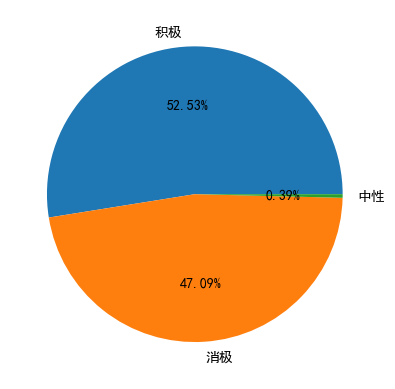

In [291]:
plt.rcParams['font.sans-serif'] = 'simhei'
data = [676,606,5]
label = ['积极', '消极', '中性'] 
plt.pie(data, labels = label, autopct='%.2f%%')
plt.show()

以上饼状图可看出积极和消极倾向基本各占一半，而中性的倾向占比很小，大概可了解到大学生对于封校的讨论情绪比较两极化。

七、结论

在本次实验中，我们爬取了B站平台播放量较高、围绕大学生封校这一主题的多个视频下方的评论来作为实验数据。在实验开始前我们对数据进行了一些
必要的清洗来减少干扰，并通过选取中国停用词表、在实验过程中不断更新此表的方式来增加实验的准确率。

首先我们是通过python中的jieba库和wordCloud库来实现对数据的分词和可视化。wordCloud在让数据可视化的同时也能够清晰的突出数据集的重点，
在词云图中字体越大的词代表出现的频次越高。通过生成的词云图，我们发现对于封校话题的讨论，“解封”、“快递”、“外卖”、“网课”、
“宿舍”、“青春”、“生活”、“羡慕”、“毕业”、“出去”、“疯”等词汇在每个数据集中出现的频率都很高，由此我们能够初步判断在疫情封校
的期间，大学生对此的讨论高度聚焦在解封外出、快递外卖等诉求中，同时也包括了对于“青春”与“生活”的讨论。

接着我们又进一步对评论进行了情感倾向分析。此步骤的实现我们借助了百度开源的api，对每条评论进行分析并得到结果后，我们选取了置信度在95%以上
所有分析结果来统计对于封校讨论的情感倾向。情感倾向的结果分为正向、消极和中性三种，我们得到的结果是正向情感和消极情感基本持平，中性情绪占比极小，由此我们大学生对于封校的讨论情绪比较两极化。

In [ ]:
此外我们还通过计算每个评论集中词汇的tfidf值来挖掘各评论集的特征。通过对词汇的tfidf计算，我么发现除了与其他评论集雷同的高频词汇，每个评论集
其实都出现了区别于其他评论集的词，其中“教职工”、“解封”、“做主”、“羡慕”等词的tfidf值较高。在我们选取的封校主题的视频中，内容既有
大学生封校期间在校娱乐的方式，也有大学生对封校的吐槽与思考，通过对tfidf值对主题词的提取，能够清楚地展示评论所聚焦的不同主题。